In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [3]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [9]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fullhour/fog_dataset_fulltime.hdf"
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']
df_train['delta_theta'] = df_train['theta925'] - df_train['theta1000']
df_train['delta_theta_e'] = df_train['theta_e925'] - df_train['theta_e1000']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']
df_valid['delta_theta'] = df_valid['theta925'] - df_valid['theta1000']
df_valid['delta_theta_e'] = df_valid['theta_e925'] - df_valid['theta_e1000']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']
df_test['delta_theta'] = df_test['theta925'] - df_test['theta1000']
df_test['delta_theta_e'] = df_test['theta_e925'] - df_test['theta_e1000']

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour','delta_theta','delta_theta_e','theta_e925']
# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.fit_transform(valid_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]


['/test', '/train', '/valid']
(60040, 18)
(60040,)


In [7]:
print(df_train.columns)

Index(['visi', 'v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk',
       'vwnd1000', 'vwnd950', 'vwnd925', 'vwnd900', 'vwnd850', 'uwnd1000',
       'uwnd950', 'uwnd925', 'uwnd900', 'uwnd850', 'temp1000', 'temp950',
       'temp925', 'temp900', 'temp850', 'rhum1000', 'rhum950', 'rhum925',
       'rhum900', 'rhum850', 'theta_e1000', 'theta1000', 'theta_e950',
       'theta950', 'theta_e925', 'theta925', 'theta_e900', 'theta900',
       'theta_e850', 'theta850', 'actual_time', 'init_time', 'year', 'month',
       'day', 'hour', 'year_sin', 'year_cos', 'day_sin', 'day_cos',
       'station_vis', 'station_rain1', 'fc_hour', 'station_vis_cat',
       'station_vis_linear', 't_td', 'td_sst', 't_sst'],
      dtype='object')


In [160]:
train_x[:,0:3]

array([[ 7.22698975, -8.03289795, -0.8059082 ],
       [ 2.08071899, -3.93084717, -1.85012817],
       [ 3.546875  , -3.62072754, -0.07385254],
       ...,
       [ 2.21875   , -2.43707275, -0.21832275],
       [ 2.65200806, -4.80477905, -2.152771  ],
       [ 3.86972046, -5.04449463, -1.17477417]])

In [10]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Dense(60, activation='relu',
                       input_shape=train_x_scaled.shape[1:]),                 
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1),
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="mean_squared_error", optimizer="sgd")

In [7]:
train_x_scaled.shape[1:]

(15,)

In [8]:
model.layers

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                480       
                                                                 
 dense_1 (Dense)             (None, 6)                 186       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [11]:
# H:/github/python/seafog/
logdir = './callbacks_reg_fulltime'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
1877/1877 [==============================] - 9s 4ms/step - loss: 0.2517 - val_loss: 0.2444
Epoch 2/50
1877/1877 [==============================] - 6s 3ms/step - loss: 0.2070 - val_loss: 0.2421
Epoch 3/50
1877/1877 [==============================] - 5s 2ms/step - loss: 0.1963 - val_loss: 0.2314
Epoch 4/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1891 - val_loss: 0.2297
Epoch 5/50
1877/1877 [==============================] - 5s 2ms/step - loss: 0.1842 - val_loss: 0.2363
Epoch 6/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.1807 - val_loss: 0.2122
Epoch 7/50
1877/1877 [==============================] - 5s 2ms/step - loss: 0.1776 - val_loss: 0.2145
Epoch 8/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1750 - val_loss: 0.2045
Epoch 9/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.1728 - val_loss: 0.2222
Epoch 10/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.170

In [12]:
type(history)

keras.callbacks.History

In [13]:
history.history

{'loss': [0.2516607940196991,
  0.2070043385028839,
  0.19631148874759674,
  0.18905951082706451,
  0.18422767519950867,
  0.1807163506746292,
  0.17759768664836884,
  0.17496173083782196,
  0.17277124524116516,
  0.17070241272449493,
  0.16858316957950592,
  0.16746623814105988,
  0.1658293604850769,
  0.16445717215538025,
  0.16286510229110718,
  0.16166706383228302,
  0.16115425527095795,
  0.15997089445590973,
  0.1591198742389679,
  0.15799447894096375,
  0.1572858691215515,
  0.156692236661911,
  0.15569601953029633,
  0.15522757172584534,
  0.15440978109836578,
  0.15386268496513367],
 'val_loss': [0.24444608390331268,
  0.24208605289459229,
  0.2313992977142334,
  0.22969569265842438,
  0.23630134761333466,
  0.21221016347408295,
  0.2144690752029419,
  0.2045438140630722,
  0.22224581241607666,
  0.21973378956317902,
  0.199758842587471,
  0.21975651383399963,
  0.21476636826992035,
  0.19425205886363983,
  0.20270830392837524,
  0.19557629525661469,
  0.20642800629138947,
  0

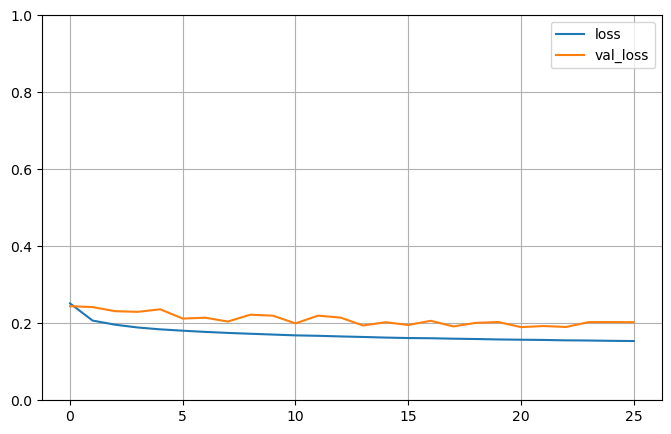

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.23997338116168976

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3

In [15]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.2415626347064972

In [16]:
predictions = model(test_x_scaled).numpy()
predictions

array([[1.1170455],
       [1.0629134],
       [0.659623 ],
       ...,
       [2.2863686],
       [2.6261444],
       [2.3564599]], dtype=float32)

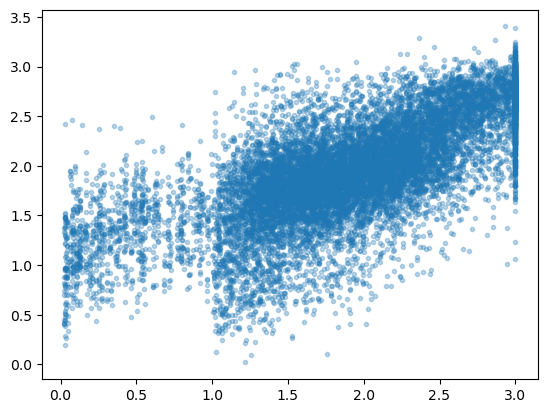

In [17]:
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()

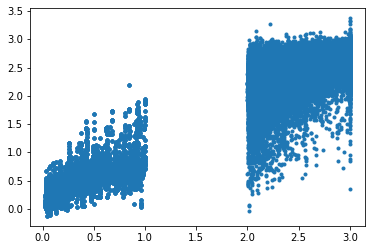

In [14]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.')
plt.show()

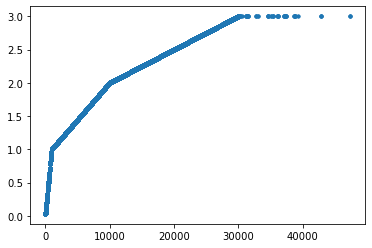

In [17]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

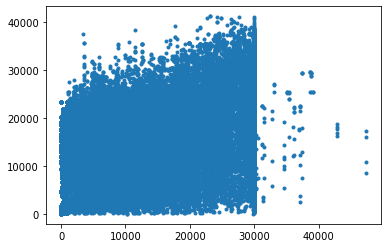

In [55]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

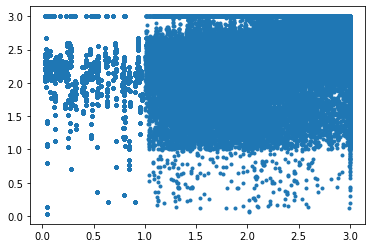

1.2369055392943231


In [100]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 